#### This notebook plots the strength of the AMOC as a time series.

In [2]:
import cosima_cookbook as cc
import numpy as np
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
import cmocean as cm
from scipy.optimize import curve_fit
from xhistogram.xarray import histogram
from collections import OrderedDict

from dask.distributed import Client

%matplotlib inline

In [3]:
client = Client(n_workers=8)
display(client)

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/42335/status,
Dashboard: /proxy/42335/status,Workers: 8
Total threads: 8,Total memory: 90.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:35293,Workers: 8
Dashboard: /proxy/42335/status,Total threads: 8
Started: Just now,Total memory: 90.00 GiB
Comm: tcp://10.6.122.24:39753,Total threads: 1
Dashboard: /proxy/34901/status,Memory: 11.25 GiB
Nanny: tcp://127.0.0.1:44909,


In [4]:
### Generate new database

db = '/scratch/e14/mp2135/access-om2/archive/databases/1deg_jra55_ryf_experiments_abrupt_spinup500.db'

session = cc.database.create_session(db)

In [5]:
exptdict = OrderedDict([
    ('Warming',  {'expt': '1deg_jra55_ryf_RCPwarm_humid_x1'}),
    ('Control',  {'expt': '1deg_jra55_ryf_cont'}),
    ('Cooling',  {'expt': '1deg_jra55_ryf_RCPcool_humid_x1'})
])


/g/data/hh5/public/apps/miniconda3/envs/analysis3-21.07/lib/python3.9/site-packages/xarray/coding/times.py:527: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/g/data/hh5/public/apps/miniconda3/envs/analysis3-21.07/lib/python3.9/site-packages/xarray/coding/times.py:527: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/g/data/hh5/public/apps/miniconda3/envs/analysis3-21.07/lib/python3.9/site-packages/xarray/coding/times.py:527: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datet

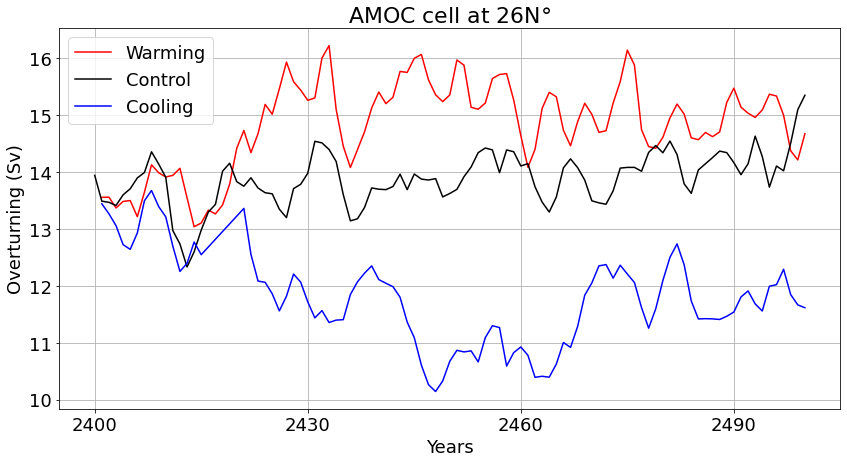

In [78]:
keys = ['Warming', 'Control', 'Cooling']#['Warming','Cooling','Control']
colors = {'Warming': 'r','Control': 'k','Cooling':'b'} #{'Control': 'k','Warming': 'r','Warming x2': 'r','Cooling':'b','Cooling x2':'b'}
linestyles = {'Warming': '-','Control': '-','Cooling':'-'} #{'Control': '-','Warming': '-','Warming x2': '--','Cooling':'-','Cooling x2':'--'}
yr_beg = '2400-01-01'
yr_end = '2499-12-31'

plt.figure(figsize=(14, 7))

for ekey in exptdict:
    expt = exptdict[ekey]['expt']
    
    var = cc.querying.getvar(expt, 'ty_trans_rho', session, start_time = yr_beg, end_time = yr_end)
    psi_amoc = var.sel(grid_xt_ocean = slice(- 103, - 5)).sum('grid_xt_ocean').sel(method = 'Nearest', grid_yu_ocean = 26) * 1.0e-9
    psi_amoc_sum = psi_amoc.cumsum('potrho') - psi_amoc.sum('potrho')
    
    try:
        var2 = cc.querying.getvar(expt,'ty_trans_rho_gm', session, start_time = yr_beg)
        psi_amoc_gm = var2.sel(grid_xt_ocean = slice( - 103, - 5)).sum('grid_xt_ocean').sel(method = 'Nearest', grid_yu_ocean = 26) * 1.0e-9
        psi_amoc_sum = psi_amoc_sum + psi_amoc_gm
    except:
        print('GM term not found')
        
    psi_amoc_sum = psi_amoc_sum.sel(potrho = slice(1035.5, None)).max('potrho').resample(time = 'Y').mean().dropna('time')
    psi_amoc_sum.plot(label = ekey, color = colors[ekey], linestyle = linestyles[ekey])
    
xlims = plt.xlim()
plt.xlabel('Years', fontsize=18)
plt.ylabel('Overturning (Sv)', fontsize=18)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.legend(fontsize=18)
plt.title('AMOC cell at 26N$\degree$', fontsize=22)
plt.grid()
plt.savefig('ch2_AMOC_26N_2400-2500.jpg', bbox_inches='tight', dpi=100)
